In [8]:
import sys
sys.path.append("../lib/")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV, cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Normalizer, StandardScaler

from sklearn.decomposition import PCA, NMF
from sklearn.cluster import FeatureAgglomeration
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, l1_min_c, SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from lightgbm import LGBMClassifier
from sklearn.feature_selection import SelectFromModel

In [9]:
from raman_lib.preprocessing import SavGolFilter, RangeLimiter, BaselineCorrector, PeakPicker
from raman_lib.misc import load_data
from raman_lib.crossvalidation import CrossValidator

In [10]:
data = load_data("../results/L_540_2022_C_E/L_540_2022_C_E_preprocessed.csv")
data

,label,file,450.0,450.5,451.0,451.5,452.0,452.5,453.0,453.5,...,1795.5,1796.0,1796.5,1797.0,1797.5,1798.0,1798.5,1799.0,1799.5,1800.0
0,Control,/home/daniel/Raman_Daten/L_540_2022/Control/C2.49,0.013701,0.013728,0.013620,0.013407,0.013117,0.012779,0.012421,0.012072,...,0.009955,0.009956,0.009952,0.009945,0.009934,0.009918,0.009896,0.009869,0.009837,0.009798
1,Control,/home/daniel/Raman_Daten/L_540_2022/Control/C2.2,0.004187,0.004239,0.004317,0.004414,0.004525,0.004643,0.004762,0.004875,...,0.005087,0.005118,0.005145,0.005165,0.005181,0.005196,0.005209,0.005221,0.005233,0.005246
2,Control,/home/daniel/Raman_Daten/L_540_2022/Control/C2.28,0.011587,0.011704,0.011808,0.011915,0.012040,0.012199,0.012408,0.012683,...,0.006265,0.006266,0.006286,0.006319,0.006355,0.006391,0.006421,0.006443,0.006452,0.006443
3,Control,/home/daniel/Raman_Daten/L_540_2022/Control/C2.41,0.008411,0.007978,0.007567,0.007175,0.006800,0.006439,0.006091,0.005754,...,0.005383,0.005487,0.005583,0.005649,0.005707,0.005759,0.005806,0.005851,0.005895,0.005940
4,Control,/home/daniel/Raman_Daten/L_540_2022/Control/C3.75,0.005633,0.005434,0.005154,0.004815,0.004441,0.004055,0.003679,0.003337,...,0.006579,0.006585,0.006582,0.006600,0.006614,0.006621,0.006618,0.006602,0.006569,0.006518
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,Etoposide,/home/daniel/Raman_Daten/L_540_2022/Etoposide/...,0.008134,0.008513,0.008750,0.008864,0.008874,0.008796,0.008650,0.008454,...,0.008019,0.007989,0.008051,0.008188,0.008337,0.008478,0.008592,0.008661,0.008665,0.008587
596,Etoposide,/home/daniel/Raman_Daten/L_540_2022/Etoposide/...,0.024164,0.020906,0.018580,0.017054,0.016196,0.015874,0.015956,0.016312,...,0.012651,0.013875,0.014889,0.015762,0.016375,0.016665,0.016569,0.016022,0.014960,0.013320
597,Etoposide,/home/daniel/Raman_Daten/L_540_2022/Etoposide/...,0.013471,0.012391,0.011882,0.011867,0.012267,0.013001,0.013992,0.015160,...,0.008442,0.008252,0.008134,0.008192,0.008352,0.008605,0.008939,0.009346,0.009817,0.010341
598,Etoposide,/home/daniel/Raman_Daten/L_540_2022/Etoposide/...,0.021773,0.018264,0.015629,0.013736,0.012455,0.011653,0.011199,0.010962,...,0.011618,0.012900,0.013818,0.014764,0.015339,0.015411,0.014852,0.013533,0.011325,0.008099


In [11]:
X = data.drop(columns=["label", "file"], errors="ignore")
wns = np.asarray(X.columns.astype(float))
X = np.asarray(X)
y = np.asarray(data.label)
y, y_key = pd.factorize(y)

In [12]:
X_orig = X.copy()
X = BaselineCorrector().fit_transform(X)

rl = RangeLimiter(lim=(450, 1670), reference=wns)
X = rl.fit_transform(X)
wns = wns[rl.lim_[0]:rl.lim_[1]]

X = SavGolFilter().fit_transform(X)

X = Normalizer().fit_transform(X)

In [27]:

clf = Pipeline([("pca", NMF(init="nndsvd", tol=1e-2, max_iter=5000)),
                ("lda", LinearDiscriminantAnalysis())])

param_grid = {"pca__n_components": range(5, 51, 5)}

In [28]:
cv = CrossValidator(clf,
                    param_grid,
                    scoring=["roc_auc", "accuracy"],
                    refit="roc_auc",
                    coef_func=lambda x: np.matmul(x[0].components_.T,
                                                  x[1].scalings_),
                    feature_names=wns,
                    n_folds=5,
                    n_trials=5,
                    n_jobs=-1
                    ).fit(X, y)

  0%|          | 0/5 [00:00<?, ?it/s]

In [29]:
pd.DataFrame(cv.ct_results_)

,train_roc_auc,test_roc_auc,train_accuracy,test_accuracy,fit_time,predict_time,p_value
0,0.957517,0.942056,0.882500,0.856667,12.299802,0.007127,4.152102e-34
1,0.957712,0.940333,0.883750,0.855000,11.466722,0.006995,4.017797e-34
2,0.956573,0.945167,0.883333,0.861667,13.046420,0.007530,1.053198e-34
3,0.958854,0.934889,0.891250,0.846667,12.296942,0.006887,3.951960e-33
4,0.954406,0.940500,0.883333,0.856667,12.314917,0.003599,4.152102e-34


In [30]:
pd.DataFrame(cv.cv_results_)

,param_pca__n_components,train_roc_auc_0,test_roc_auc_0,train_accuracy_0,test_accuracy_0,train_roc_auc_1,test_roc_auc_1,train_accuracy_1,test_accuracy_1,train_roc_auc_2,...,train_accuracy_2,test_accuracy_2,train_roc_auc_3,test_roc_auc_3,train_accuracy_3,test_accuracy_3,train_roc_auc_4,test_roc_auc_4,train_accuracy_4,test_accuracy_4
0,5,0.938733,0.935889,0.853333,0.848333,0.938750,0.937389,0.854167,0.843333,0.938809,...,0.851667,0.845000,0.939111,0.936556,0.855000,0.853333,0.938951,0.935833,0.857917,0.855000
1,10,0.945431,0.939389,0.864583,0.855000,0.945122,0.936556,0.862917,0.853333,0.945604,...,0.862083,0.855000,0.944451,0.939833,0.863333,0.856667,0.945149,0.940444,0.863750,0.843333
2,15,0.952632,0.941056,0.882083,0.865000,0.952063,0.945778,0.880833,0.868333,0.952264,...,0.880833,0.866667,0.952622,0.943333,0.876667,0.866667,0.951628,0.944778,0.877500,0.873333
3,20,0.956299,0.944000,0.882500,0.855000,0.955778,0.945444,0.882500,0.858333,0.955701,...,0.880417,0.863333,0.956632,0.944556,0.882083,0.856667,0.957045,0.941944,0.888333,0.855000
4,25,0.958163,0.943167,0.884167,0.858333,0.957583,0.944056,0.882083,0.861667,0.956684,...,0.884583,0.868333,0.956997,0.941389,0.880417,0.858333,0.957302,0.944389,0.883750,0.863333
5,30,0.958819,0.943500,0.885000,0.858333,0.959969,0.939889,0.884583,0.856667,0.959715,...,0.882083,0.866667,0.959556,0.938389,0.886667,0.855000,0.960872,0.942611,0.885000,0.866667
6,35,0.961938,0.943111,0.894583,0.863333,0.962587,0.941056,0.894583,0.865000,0.962375,...,0.892500,0.873333,0.962535,0.937556,0.890417,0.861667,0.962347,0.939944,0.892500,0.861667
7,40,0.964497,0.944556,0.900833,0.856667,0.964674,0.942889,0.897083,0.860000,0.964799,...,0.895000,0.863333,0.966365,0.937778,0.902917,0.853333,0.966042,0.942000,0.898750,0.868333
8,45,0.967955,0.946944,0.902500,0.863333,0.968639,0.939333,0.904167,0.865000,0.968167,...,0.902917,0.871667,0.968528,0.938500,0.905417,0.863333,0.967885,0.943667,0.898750,0.873333
9,50,0.968687,0.946222,0.904167,0.866667,0.970583,0.941833,0.907500,0.860000,0.969840,...,0.902917,0.871667,0.969472,0.935556,0.906250,0.850000,0.970285,0.940722,0.902083,0.876667


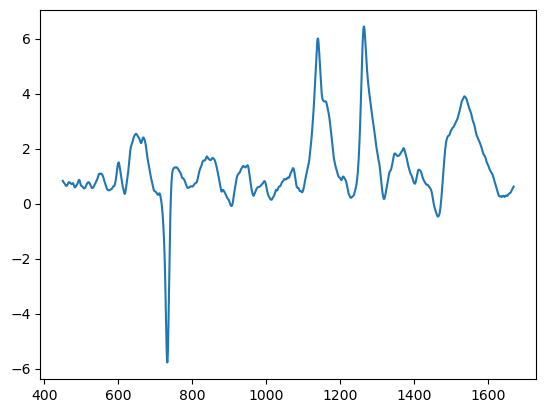

In [31]:
plt.plot(wns, np.mean(cv.coefs_, axis=0))

In [44]:
shap.dependence_plot("rank(1)", cv.shap_results_.values, cv.shap_results_.data, feature_names=cv.shap_results_.feature_names)

AttributeError: 'CrossValidator' object has no attribute 'shap_results_'

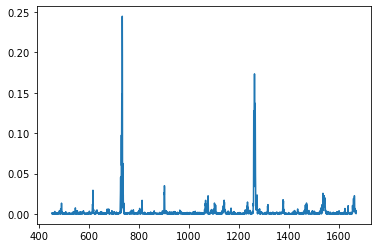

In [100]:
plt.plot(wns, np.mean(np.absolute(cv.shap_results_.values), axis=0))

In [ ]:
# %matplotlib widget
# from raman_lib.visualization import plot_spectra_peaks

# plot_spectra_peaks(wns, X_orig[y_false], labels=np.asarray(data.file)[y_false])

ValueError: invalid literal for int() with base 10: '1.0'